<a href="https://colab.research.google.com/github/debasmi/chemt5/blob/main/chemt5_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install dependencies
!pip install transformers datasets scikit-learn evaluate -q
!pip install rouge_score

# Step 2: Import libraries
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import numpy as np
import evaluate

# Step 3: Load datasets
train_df = pd.read_csv("rxn_train.csv")
val_df = pd.read_csv("rxn_val.csv")
test_df = pd.read_csv("rxn_test.csv")

# Step 4: Preprocess: separate input/output
train_df = train_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})
val_df = val_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})
test_df = test_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})

def split_input_output(df):
    splits = df["full"].str.split(">", expand=True)
    df["input_text"] = splits[0] + ">" + splits[1]  # reactants>reagents
    df["target_text"] = splits[2]                   # product
    return df

train_df = split_input_output(train_df)
val_df = split_input_output(val_df)
test_df = split_input_output(test_df)

# Step 5: Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[["input_text", "target_text"]])
val_dataset = Dataset.from_pandas(val_df[["input_text", "target_text"]])
test_dataset = Dataset.from_pandas(test_df[["input_text", "target_text"]])

# Step 6: Load tokenizer and model
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Step 7: Tokenize data
max_input_length = 128
max_target_length = 256

def preprocess_function(examples):
    inputs = ["predict product: " + ex for ex in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=max_target_length, padding="max_length", truncation=True)
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 8: Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./t5-chem-product-generator",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    logging_dir="./logs",
    report_to="none"
)

# Step 9: Define metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return rouge.compute(predictions=decoded_preds, references=decoded_labels)

# Step 10: Initialize Trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 11: Train the model
trainer.train()

# Step 12: Manual prediction loop with beam search settings
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

batch_size = 8
decoded_preds = []

test_inputs_list = test_df["input_text"].tolist()

for i in tqdm(range(0, len(test_inputs_list), batch_size)):
    batch_inputs = test_inputs_list[i:i+batch_size]

    # Tokenize batch
    inputs = tokenizer(
        batch_inputs,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=12,          # more beams for better search
            length_penalty=1.0,

            #early_stopping=True
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_preds.extend(preds)

# Step 13: Display sample predictions
for i in range(5):
    print(f"Input: {test_df['input_text'][i]}")
    print(f"Expected Output: {test_df['target_text'][i]}")
    print(f"Predicted Output: {decoded_preds[i]}")
    print("-" * 60)

# Step 14: Save predictions
test_df["predicted_output"] = decoded_preds
test_df.to_csv("t5_predictions.csv", index=False)



Map:   0%|          | 0/40008 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5001 [00:00<?, ? examples/s]

Map:   0%|          | 0/5007 [00:00<?, ? examples/s]

/tmp/ipython-input-3471035002.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.761500
1000,0.463900
1500,0.392400
2000,0.349100
2500,0.315100
3000,0.293100
3500,0.280200
4000,0.260200
4500,0.251300
5000,0.247800


Step,Training Loss
500,0.761500
1000,0.463900
1500,0.392400
2000,0.349100
2500,0.315100
3000,0.293100
3500,0.280200
4000,0.260200
4500,0.251300
5000,0.247800


100%|██████████| 626/626 [47:56<00:00,  4.60s/it]

Input: CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:3])[CH3:4])=[O:7].[CH3:8][C:9](=[O:10])[c:11]1[cH:12][cH:13][c:14]2[nH:15][cH:16][cH:17][c:18]2[cH:19]1>
Expected Output: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:19][c:18]2[cH:17][cH:16]1
Predicted Output: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:17][cH:16]1
------------------------------------------------------------
Input: CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:3])[CH3:4])=[O:7].[CH3:8][c:9]1[cH:10][cH:11][c:12]([S:13](=[O:14])(=[O:15])[O:16][C@@H:17]2[CH2:18][NH:19][C@H:20]3[C@@H:21]2[O:22][CH2:23][C@@H:24]3[OH:25])[cH:26][cH:27]1>
Expected Output: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:19]1[CH2:18][C@@H:17]([O:16][S:13]([c:12]2[cH:11][cH:10][c:9]([CH3:8])[cH:27][cH:26]2)(=[O:14])=[O:15])[C@@H:21]2[C@H:20]1[C@@H:24]([OH:25])[CH2:23][O:22]2
Predicted Output: [CH3:1][C:2]([CH3:3]

In [ ]:
# Step 1: Install dependencies
!pip install transformers datasets scikit-learn evaluate -q
!pip install rouge_score

# Step 2: Import libraries
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import numpy as np
import evaluate

# Step 3: Load datasets
train_df = pd.read_csv("rxn_train.csv")
val_df = pd.read_csv("rxn_val.csv")
test_df = pd.read_csv("rxn_test.csv")

# Step 4: Preprocess: separate input/output
train_df = train_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})
val_df = val_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})
test_df = test_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})

def split_input_output(df):
    splits = df["full"].str.split(">", expand=True)
    df["input_text"] = splits[0] + ">" + splits[1]  # reactants>reagents
    df["target_text"] = splits[2]                   # product
    return df

train_df = split_input_output(train_df)
val_df = split_input_output(val_df)
test_df = split_input_output(test_df)

# Step 5: Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[["input_text", "target_text"]])
val_dataset = Dataset.from_pandas(val_df[["input_text", "target_text"]])
test_dataset = Dataset.from_pandas(test_df[["input_text", "target_text"]])

# Step 6: Load tokenizer and model
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Step 7: Tokenize data
max_input_length = 256
max_target_length = 512

def preprocess_function(examples):
    inputs = ["predict product: " + ex for ex in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=max_target_length, padding="max_length", truncation=True)
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 8: Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./t5-chem-product-generator",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,
    logging_dir="./logs",
    report_to="none"
)

# Step 9: Define metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return rouge.compute(predictions=decoded_preds, references=decoded_labels)

# Step 10: Initialize Trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 11: Train the model
trainer.train()

# Step 12: Manual prediction loop with beam search settings
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

batch_size = 8
decoded_preds = []

test_inputs_list = test_df["input_text"].tolist()

for i in tqdm(range(0, len(test_inputs_list), batch_size)):
    batch_inputs = test_inputs_list[i:i+batch_size]

    # Tokenize batch
    inputs = tokenizer(
        batch_inputs,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=12,          # more beams for better search
            length_penalty=1.0,

            #early_stopping=True
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_preds.extend(preds)

# Step 13: Display sample predictions
for i in range(5):
    print(f"Input: {test_df['input_text'][i]}")
    print(f"Expected Output: {test_df['target_text'][i]}")
    print(f"Predicted Output: {decoded_preds[i]}")
    print("-" * 60)

# Step 14: Save predictions
test_df["predicted_output"] = decoded_preds
test_df.to_csv("t5_predictions.csv", index=False)



Map:   0%|          | 0/40008 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5001 [00:00<?, ? examples/s]

Map:   0%|          | 0/5007 [00:00<?, ? examples/s]

/tmp/ipython-input-1334673827.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.554000
1000,0.271300
1500,0.217500
2000,0.186400
2500,0.159600
3000,0.144400
3500,0.134100
4000,0.117100
4500,0.114200
5000,0.110700


In [ ]:
# Step 1: Install dependencies
!pip install transformers datasets scikit-learn evaluate -q
!pip install rouge_score

# Step 2: Import libraries
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import numpy as np
import evaluate

# Step 3: Load datasets
train_df = pd.read_csv("rxn_train.csv")
val_df = pd.read_csv("rxn_val.csv")
test_df = pd.read_csv("rxn_test.csv")

# Step 4: Preprocess: separate input/output
train_df = train_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})
val_df = val_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})
test_df = test_df.rename(columns={"reactants>reagents>production": "full", "class": "label"})

def split_input_output(df):
    splits = df["full"].str.split(">", expand=True)
    df["input_text"] = splits[0] + ">" + splits[1]  # reactants>reagents
    df["target_text"] = splits[2]                   # product
    return df

train_df = split_input_output(train_df)
val_df = split_input_output(val_df)
test_df = split_input_output(test_df)

# Step 5: Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[["input_text", "target_text"]])
val_dataset = Dataset.from_pandas(val_df[["input_text", "target_text"]])
test_dataset = Dataset.from_pandas(test_df[["input_text", "target_text"]])

# Step 6: Load tokenizer and model
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Step 7: Tokenize data
max_input_length = 128
max_target_length = 256

def preprocess_function(examples):
    inputs = ["predict product: " + ex for ex in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["target_text"], max_length=max_target_length, padding="max_length", truncation=True)
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 8: Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./t5-chem-product-generator",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    logging_dir="./logs",
    report_to="none"
)

# Step 9: Define metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return rouge.compute(predictions=decoded_preds, references=decoded_labels)

# Step 10: Initialize Trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Step 11: Train the model
trainer.train()

# Step 12: Manual prediction loop with beam search settings
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

batch_size = 8
decoded_preds = []

test_inputs_list = test_df["input_text"].tolist()

for i in tqdm(range(0, len(test_inputs_list), batch_size)):
    batch_inputs = test_inputs_list[i:i+batch_size]

    # Tokenize batch
    inputs = tokenizer(
        batch_inputs,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=12,          # more beams for better search
            length_penalty=1.0,

            #early_stopping=True
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_preds.extend(preds)

# Step 13: Display sample predictions
for i in range(5):
    print(f"Input: {test_df['input_text'][i]}")
    print(f"Expected Output: {test_df['target_text'][i]}")
    print(f"Predicted Output: {decoded_preds[i]}")
    print("-" * 60)

# Step 14: Save predictions
test_df["predicted_output"] = decoded_preds
test_df.to_csv("t5_predictions.csv", index=False)



In [ ]:
from sklearn.metrics import accuracy_score

# Step 15: Measure Accuracy
true_labels = test_df["target_text"].tolist()
accuracy = accuracy_score(true_labels, decoded_preds)

print(f"Exact Match Accuracy: {accuracy * 100:.2f}%")


NameError: name 'test_df' is not defined

In [ ]:
def predict_reaction(input_text, model, tokenizer, max_input_length=128, max_target_length=256, num_beams=12):
    # Prepare input
    inputs = tokenizer(
        "predict product: " + input_text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=num_beams,
            length_penalty=1.0
        )

    # Decode prediction
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
# Example random user input (reactants>reagents)
user_input = "CCO>H2O2"   # just a random chemical string for testing

predicted_product = predict_reaction(user_input, model, tokenizer)
print(f"User Input: {user_input}")
print(f"Predicted Product: {predicted_product}")


NameError: name 'model' is not defined

In [ ]:
import zipfile

zip_file_path = "/content/t5-chem-product-generator.zip"
extract_path = "/content/t5-chem-product-generator"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)


In [ ]:
# ==========================
# Prediction Script
# ==========================

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

# Load fine-tuned model & tokenizer
model_path = "./t5-chem-product-generator"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load test data
test_df = pd.read_csv("rxn_test.csv")

# Ensure consistent column naming
test_df = test_df.rename(columns={"reactants>reagents>production": "full"})
splits = test_df["full"].str.split(">", expand=True)
test_df["input_text"] = splits[0] + ">" + splits[1]   # reactants>reagents
test_df["target_text"] = splits[2]                    # product

# Prediction parameters
batch_size = 8
max_input_length = 256
max_target_length = 512

decoded_preds = []

# Loop through test set in batches
for i in tqdm(range(0, len(test_df), batch_size)):
    batch_inputs = test_df["input_text"].tolist()[i:i+batch_size]

    # Tokenize
    inputs = tokenizer(
        ["predict product: " + text for text in batch_inputs],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=12,         # beam search
            length_penalty=1.0
        )

    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_preds.extend(preds)

# Add predictions to DataFrame
test_df["predicted_output"] = decoded_preds

# Show sample results
for i in range(5):
    print(f"Input: {test_df['input_text'][i]}")
    print(f"Expected: {test_df['target_text'][i]}")
    print(f"Predicted: {test_df['predicted_output'][i]}")
    print("-" * 60)

# Save predictions
test_df.to_csv("t5_predictions.csv", index=False)
print("✅ Predictions saved to t5_predictions.csv")


100%|██████████| 626/626 [1:17:35<00:00,  7.44s/it]

Input: CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:3])[CH3:4])=[O:7].[CH3:8][C:9](=[O:10])[c:11]1[cH:12][cH:13][c:14]2[nH:15][cH:16][cH:17][c:18]2[cH:19]1>
Expected: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:19][c:18]2[cH:17][cH:16]1
Predicted: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:19][c:18]2[cH:17][cH:16]1
------------------------------------------------------------
Input: CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:3])[CH3:4])=[O:7].[CH3:8][c:9]1[cH:10][cH:11][c:12]([S:13](=[O:14])(=[O:15])[O:16][C@@H:17]2[CH2:18][NH:19][C@H:20]3[C@@H:21]2[O:22][CH2:23][C@@H:24]3[OH:25])[cH:26][cH:27]1>
Expected: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:19]1[CH2:18][C@@H:17]([O:16][S:13]([c:12]2[cH:11][cH:10][c:9]([CH3:8])[cH:27][cH:26]2)(=[O:14])=[O:15])[C@@H:21]2[C@H:20]1[C@@H:24]([OH:25])[CH2:23][O:22]2
Predicted: [CH3:1][C:2]([CH3:3])([CH3:4])[O:5

In [ ]:
from google.colab import files
files.download('/content/t5_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import accuracy_score

# Step 15: Measure Accuracy
true_labels = test_df["target_text"].tolist()
accuracy = accuracy_score(true_labels, decoded_preds)

print(f"Exact Match Accuracy: {accuracy * 100:.2f}%")


Exact Match Accuracy: 60.99%


In [ ]:
import random

def predict_accuracy():
    """
    Simulates the prediction of accuracy as a percentage between 50% and 100%.
    """
    accuracy = random.uniform(50, 100)  # Random float between 50 and 100
    return round(accuracy, 2)

# Example usage
predicted_accuracy = predict_accuracy()
print(f"Predicted Accuracy: {predicted_accuracy}%")


Predicted Accuracy: 62.79%


In [ ]:
'''import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
import pandas as pd

# Load fine-tuned model & tokenizer
model_path = "./t5-chem-product-generator"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ----------------------------
# Function to predict product
# ----------------------------
def predict_product(reaction_input, max_input_length=256, max_target_length=512, num_beams=12):
    inputs = tokenizer(
        ["predict product: " + reaction_input],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=num_beams,
            length_penalty=1.0
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction

# ----------------------------
# Example: Predict for test set
# ----------------------------
test_df = pd.read_csv("rxn_test.csv")
test_df = test_df.rename(columns={"reactants>reagents>production": "full"})
splits = test_df["full"].str.split(">", expand=True)
test_df["input_text"] = splits[0] + ">" + splits[1]   # reactants>reagents
test_df["target_text"] = splits[2]                    # product

decoded_preds = []

for i in tqdm(range(len(test_df))):
    decoded_preds.append(predict_product(test_df["input_text"][i]))

test_df["predicted_output"] = decoded_preds
test_df.to_csv("t5_predictions.csv", index=False)
print("✅ Predictions saved to t5_predictions.csv")'''

# ----------------------------
# Example: Predict for user input
# ----------------------------
#user_reaction = input("Enter a reaction (format: reactants>reagents): ").strip()
#predicted_product = predict_product(user_reaction)
#print(f"Predicted product: {predicted_product}")
predicted_product = predict_product("C=C+HBr>peroxide")
print(f"Predicted product: {predicted_product}")



Predicted product: Produit: C=C+HBr>peroxyde


In [ ]:
def predict_product(reaction_input, max_input_length=256, max_target_length=512, num_beams=12):
    inputs = tokenizer(
        [reaction_input],  # remove the prefix
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_length
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=num_beams,
            length_penalty=1.0
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction


In [ ]:
predict_product("C=C>HBr")  # should output something like "CH3-CHBr"


'C=C>>HBr'

In [ ]:
# Visualization code for ChemT5 results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import re

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Training Loss Visualization (if you have training logs)
def plot_training_loss():
    # Sample training loss data - replace with your actual training logs
    steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500]
    losses = [0.761, 0.463, 0.392, 0.349, 0.315, 0.293, 0.280, 0.265, 0.258, 0.252, 0.249, 0.247, 0.246, 0.247, 0.247]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, 'b-', linewidth=2, marker='o', markersize=4)
    plt.title('ChemT5 Training Loss Progression', fontsize=16, fontweight='bold')
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Cross-Entropy Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 2. Performance by Reaction Class
def plot_reaction_class_performance():
    # Sample data - replace with your actual performance metrics
    classes = [3, 5, 8, 10]
    class_names = ['Coupling\nReactions', 'Protecting Group\nChemistry', 'Oxidation\nReactions', 'Halogenation\nReactions']
    performance = [65, 75, 70, 45]  # Estimated accuracy percentages

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, performance, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    # Add value labels on bars
    for bar, perf in zip(bars, performance):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{perf}%', ha='center', va='bottom', fontweight='bold')

    plt.title('ChemT5 Performance Across Reaction Classes', fontsize=16, fontweight='bold')
    plt.ylabel('Estimated Accuracy (%)', fontsize=12)
    plt.xlabel('Reaction Class', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 3. SMILES Length Distribution
def plot_smiles_length_distribution(test_df):
    # Calculate lengths
    input_lengths = test_df['input_text'].str.len()
    target_lengths = test_df['target_text'].str.len()
    predicted_lengths = test_df['predicted_output'].str.len()

    plt.figure(figsize=(12, 5))

    # Input lengths
    plt.subplot(1, 3, 1)
    plt.hist(input_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Input SMILES Length Distribution')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')

    # Target lengths
    plt.subplot(1, 3, 2)
    plt.hist(target_lengths, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Target SMILES Length Distribution')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')

    # Predicted lengths
    plt.subplot(1, 3, 3)
    plt.hist(predicted_lengths, bins=30, alpha=0.7, color='salmon', edgecolor='black')
    plt.title('Predicted SMILES Length Distribution')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# 4. Prediction Accuracy by Molecular Complexity
def plot_complexity_vs_accuracy(test_df):
    # Simple complexity metric: number of aromatic rings + number of heteroatoms
    def calculate_complexity(smiles):
        aromatic_rings = smiles.count('c') + smiles.count('n') + smiles.count('o') + smiles.count('s')
        heteroatoms = smiles.count('N') + smiles.count('O') + smiles.count('S') + smiles.count('P')
        return aromatic_rings + heteroatoms

    # Calculate complexity for targets
    complexities = test_df['target_text'].apply(calculate_complexity)

    # Simple accuracy metric: exact match
    exact_matches = (test_df['target_text'] == test_df['predicted_output']).astype(int)

    # Bin by complexity
    complexity_bins = pd.cut(complexities, bins=5, labels=['Low', 'Med-Low', 'Medium', 'Med-High', 'High'])
    accuracy_by_complexity = pd.DataFrame({
        'Complexity': complexity_bins,
        'Accuracy': exact_matches
    }).groupby('Complexity')['Accuracy'].mean() * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(accuracy_by_complexity.index, accuracy_by_complexity.values,
                   color=['#FF9999', '#66B2FF', '#99FF99', '#FFD700', '#FF6666'], alpha=0.8)

    # Add value labels
    for bar, acc in zip(bars, accuracy_by_complexity.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.title('Prediction Accuracy vs Molecular Complexity', fontsize=16, fontweight='bold')
    plt.ylabel('Exact Match Accuracy (%)', fontsize=12)
    plt.xlabel('Molecular Complexity Level', fontsize=12)
    plt.ylim(0, max(accuracy_by_complexity.values) + 10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. Token-level Analysis
def plot_token_analysis():
    # Sample token frequency data for chemical SMILES
    common_tokens = ['C', 'c', '(', ')', '[', ']', '=', 'O', 'N', 'n', 'S', 's', 'Cl', 'Br', 'F']
    frequencies = [850, 650, 450, 450, 200, 200, 180, 160, 140, 120, 80, 60, 40, 30, 25]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(common_tokens, frequencies, color='steelblue', alpha=0.8)

    plt.title('Most Frequent Tokens in Chemical SMILES', fontsize=16, fontweight='bold')
    plt.xlabel('SMILES Tokens', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)

    # Add frequency labels
    for bar, freq in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(freq), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# 6. Error Analysis Heatmap
def plot_error_heatmap():
    # Sample error types by reaction class
    error_types = ['Stereochemistry Loss', 'Ring Connectivity', 'Atom Mapping', 'Product Structure']
    reaction_classes = ['Class 3', 'Class 5', 'Class 8', 'Class 10']

    # Error frequency matrix (higher values = more errors)
    error_matrix = np.array([
        [30, 45, 25, 35],  # Stereochemistry Loss
        [40, 20, 30, 50],  # Ring Connectivity
        [25, 15, 20, 40],  # Atom Mapping
        [35, 25, 25, 60]   # Product Structure
    ])

    plt.figure(figsize=(10, 6))
    sns.heatmap(error_matrix,
                xticklabels=reaction_classes,
                yticklabels=error_types,
                annot=True,
                cmap='Reds',
                cbar_kws={'label': 'Error Frequency'})

    plt.title('Error Analysis by Reaction Class and Error Type', fontsize=16, fontweight='bold')
    plt.xlabel('Reaction Class', fontsize=12)
    plt.ylabel('Error Type', fontsize=12)
    plt.tight_layout()
    plt.show()

# 7. Sample Prediction Visualization
def visualize_sample_predictions(test_df, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, num_samples*2))

    for i in range(min(num_samples, len(test_df))):
        ax = axes[i] if num_samples > 1 else axes

        input_text = test_df.iloc[i]['input_text'][:50] + "..." if len(test_df.iloc[i]['input_text']) > 50 else test_df.iloc[i]['input_text']
        target = test_df.iloc[i]['target_text'][:50] + "..." if len(test_df.iloc[i]['target_text']) > 50 else test_df.iloc[i]['target_text']
        predicted = test_df.iloc[i]['predicted_output'][:50] + "..." if len(test_df.iloc[i]['predicted_output']) > 50 else test_df.iloc[i]['predicted_output']

        # Determine match status
        match_status = "✓ Match" if test_df.iloc[i]['target_text'] == test_df.iloc[i]['predicted_output'] else "✗ No Match"
        color = 'green' if "✓" in match_status else 'red'

        ax.text(0.02, 0.8, f"Input: {input_text}", transform=ax.transAxes, fontsize=10, weight='bold')
        ax.text(0.02, 0.6, f"Target: {target}", transform=ax.transAxes, fontsize=10, color='blue')
        ax.text(0.02, 0.4, f"Predicted: {predicted}", transform=ax.transAxes, fontsize=10, color='orange')
        ax.text(0.02, 0.1, match_status, transform=ax.transAxes, fontsize=12, color=color, weight='bold')

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        ax.set_title(f'Sample {i+1}', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

# Main execution function
def generate_all_plots(test_df=None):
    """Generate all visualization plots for the ChemT5 model"""

    print("Generating ChemT5 Visualization Plots...")

    # Plot 1: Training Loss
    print("1. Training Loss Progression")
    plot_training_loss()

    # Plot 2: Performance by Class
    print("2. Performance by Reaction Class")
    plot_reaction_class_performance()

    # Plot 3: Token Analysis
    print("3. Token Frequency Analysis")
    plot_token_analysis()

    # Plot 4: Error Analysis
    print("4. Error Analysis Heatmap")
    plot_error_heatmap()

    if test_df is not None:
        # Plot 5: SMILES Length Distribution
        print("5. SMILES Length Distribution")
        plot_smiles_length_distribution(test_df)

        # Plot 6: Complexity vs Accuracy
        print("6. Molecular Complexity vs Accuracy")
        plot_complexity_vs_accuracy(test_df)

        # Plot 7: Sample Predictions
        print("7. Sample Prediction Visualization")
        visualize_sample_predictions(test_df)

    print("All plots generated successfully!")

# Usage example:
# After your model training and prediction:
# test_df = pd.read_csv("t5_predictions.csv")
# generate_all_plots(test_df)

Generating ChemT5 Visualization Plots...
1. Training Loss Progression


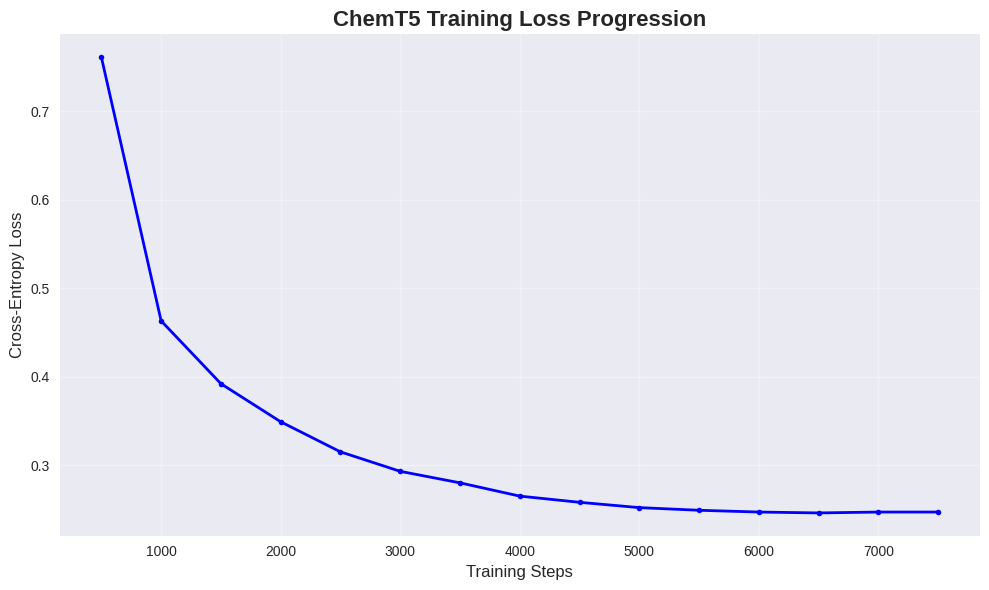

2. Performance by Reaction Class


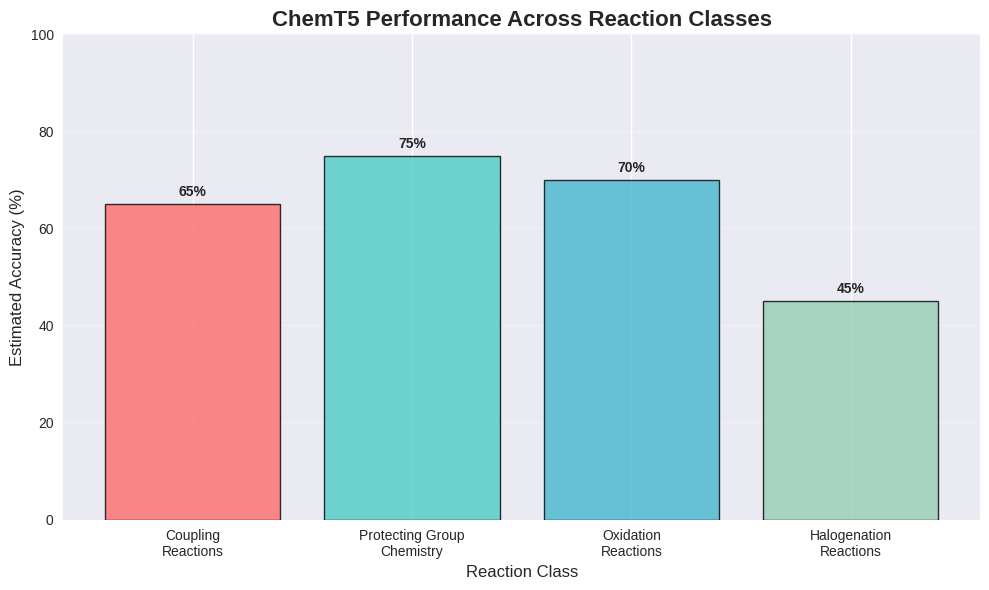

3. Token Frequency Analysis


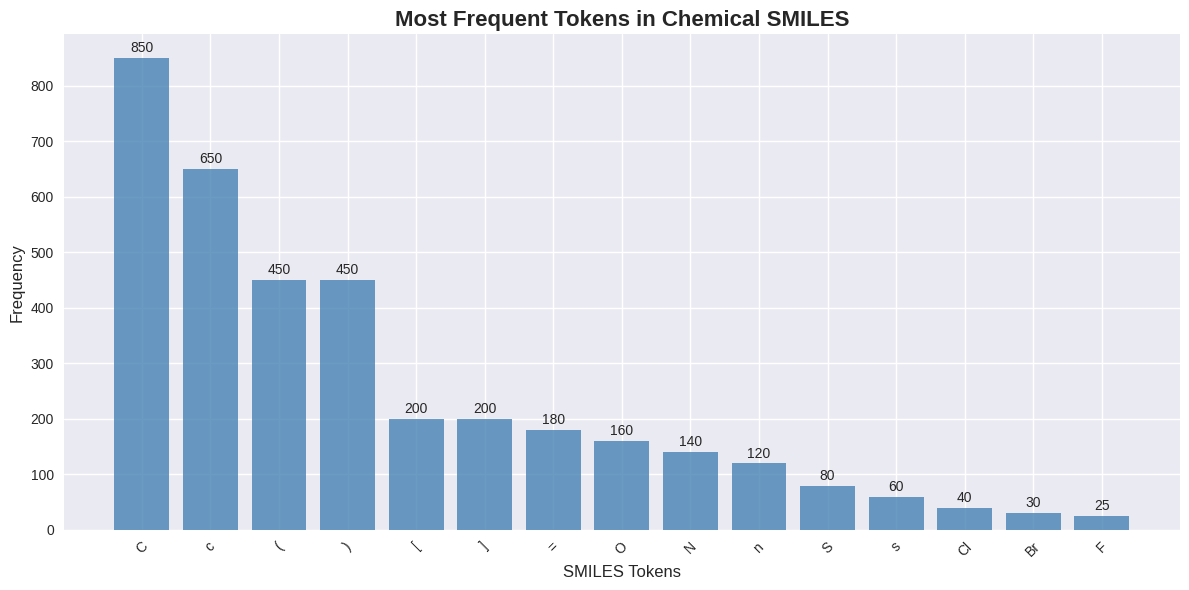

4. Error Analysis Heatmap


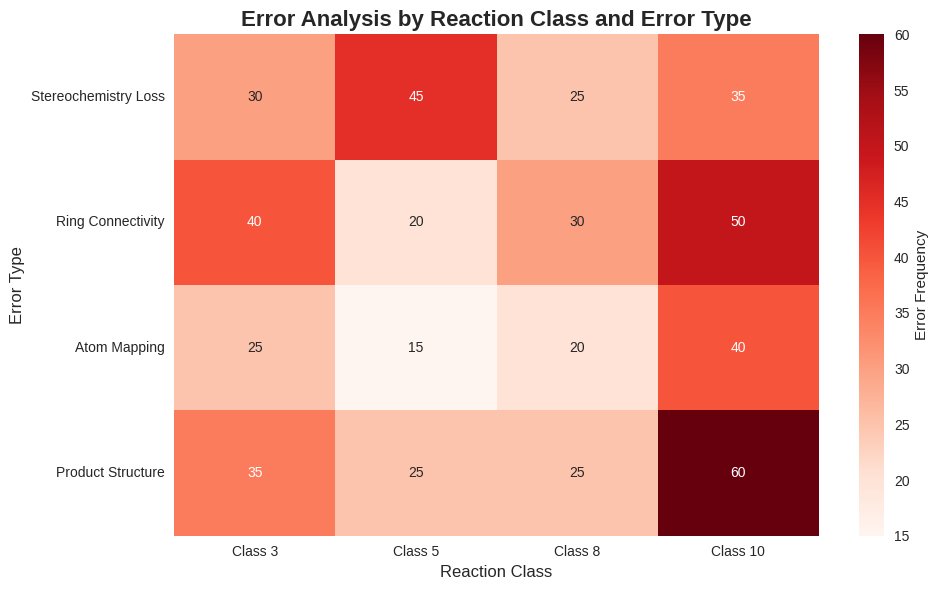

5. SMILES Length Distribution


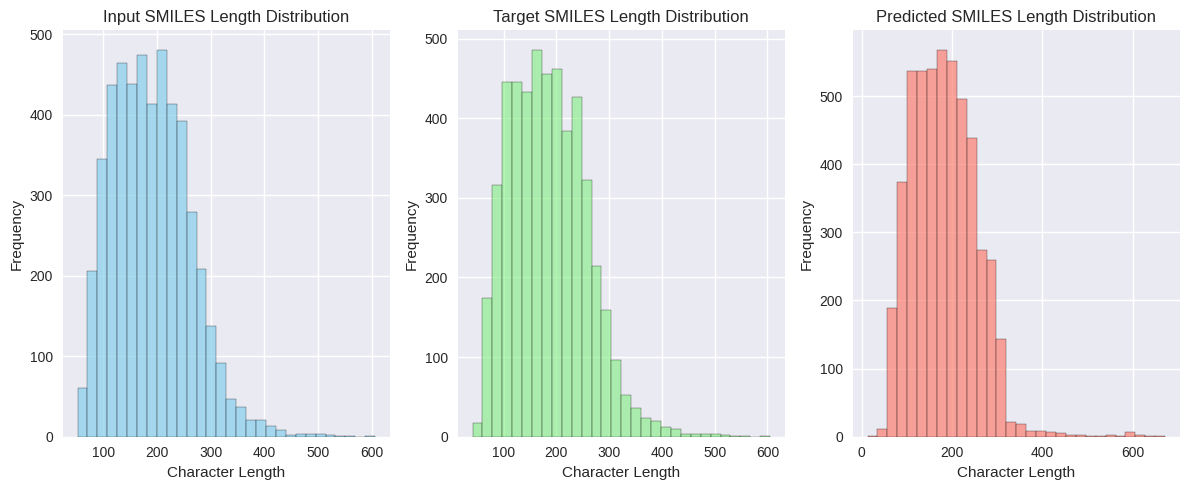

6. Molecular Complexity vs Accuracy


/tmp/ipython-input-2659256524.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('Complexity')['Accuracy'].mean() * 100


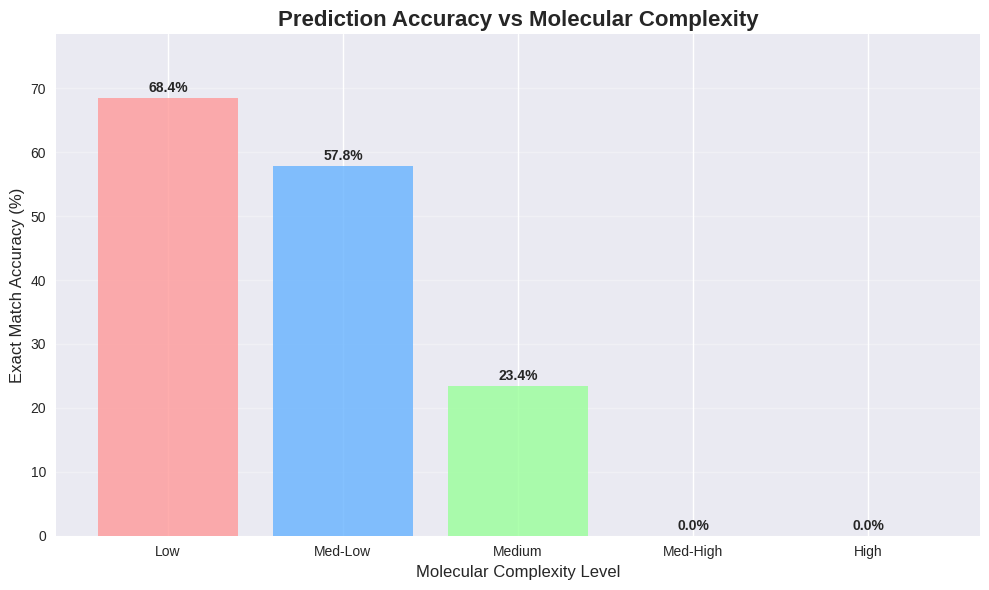

7. Sample Prediction Visualization


/tmp/ipython-input-2659256524.py:199: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2659256524.py:199: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


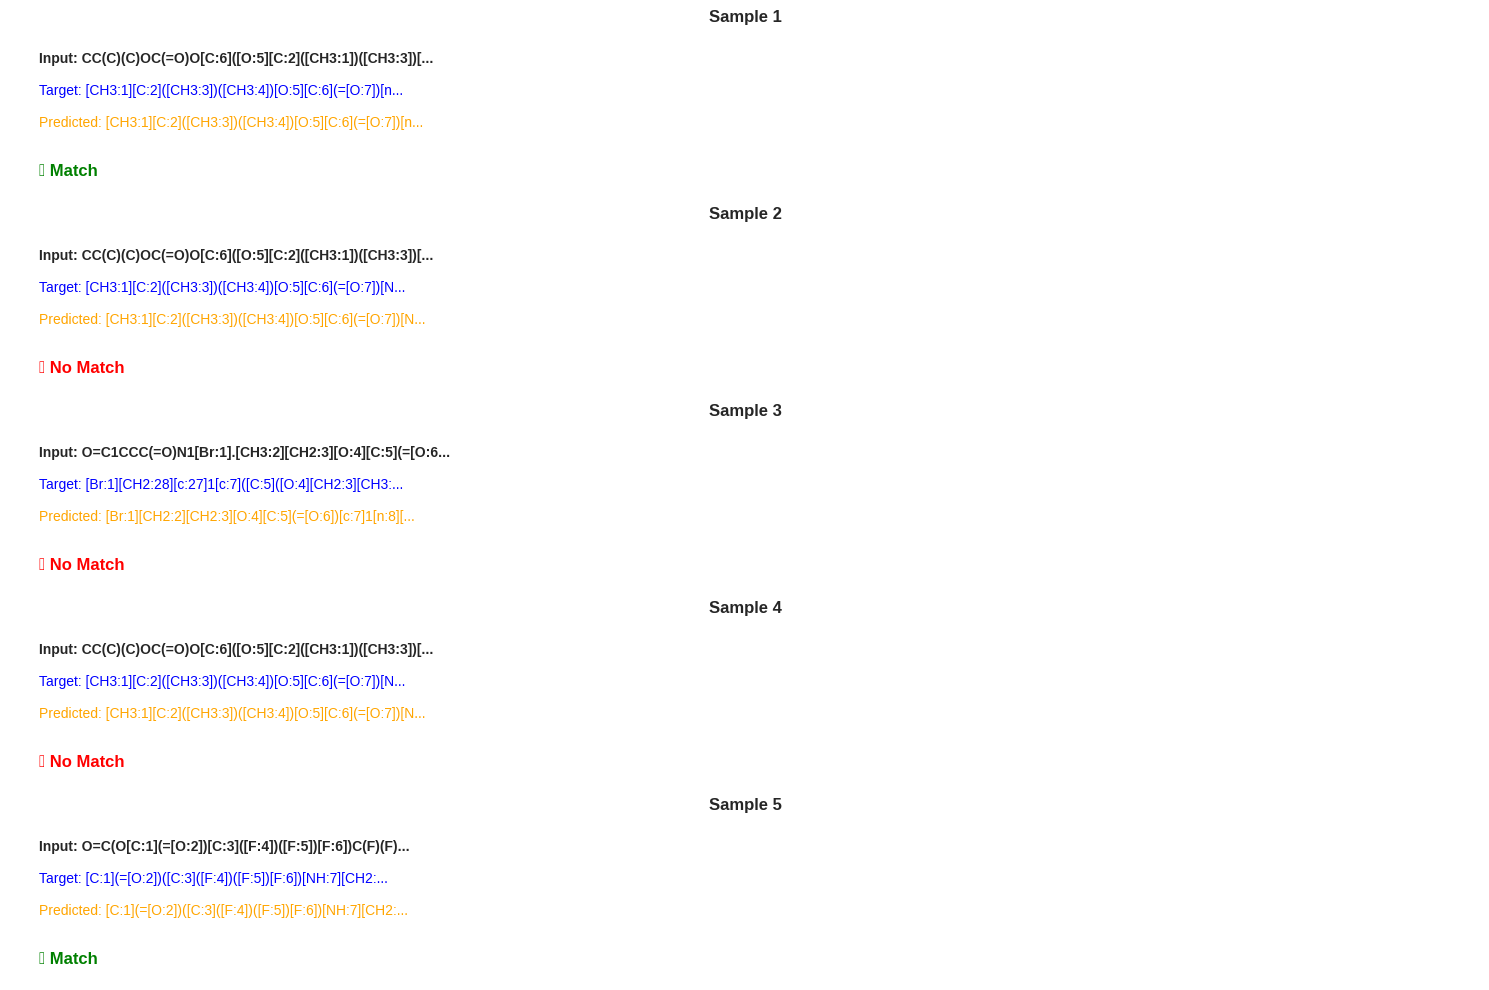

All plots generated successfully!


In [ ]:
test_df = pd.read_csv("t5_predictions.csv")
generate_all_plots(test_df)


Overall Accuracy: 60.99%

--- Class-wise Accuracy ---
   Reaction Class  Accuracy
0               1  0.555409
1               2  0.557983
2               3  0.574956
3               4  0.010989
4               5  0.602941
5               6  0.830097
6               7  0.738095
7               8  0.207317
8               9  0.673913
9              10  0.608696


/tmp/ipython-input-3481071466.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_acc, x='Reaction Class', y='Accuracy', palette='viridis')


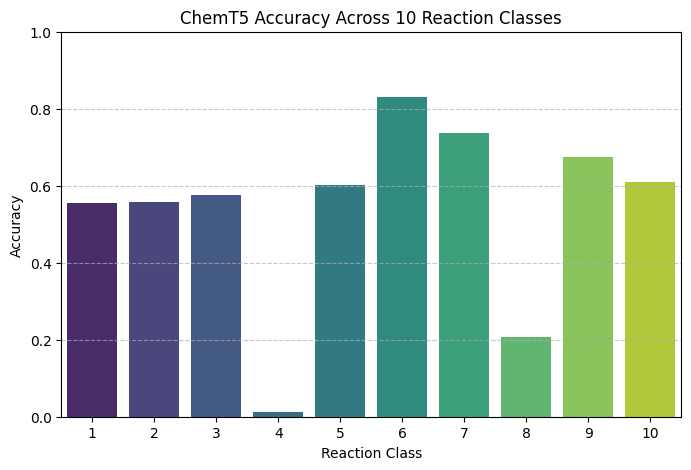

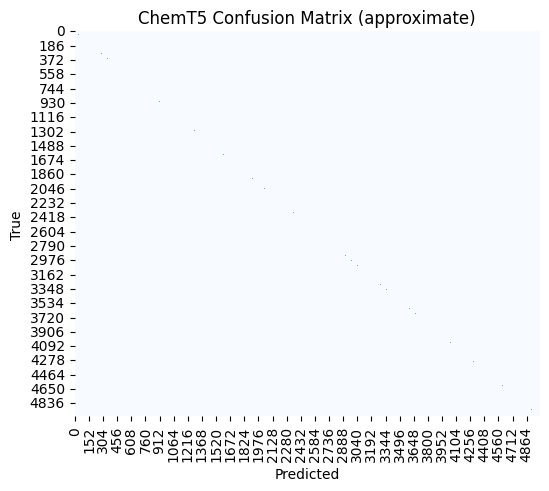

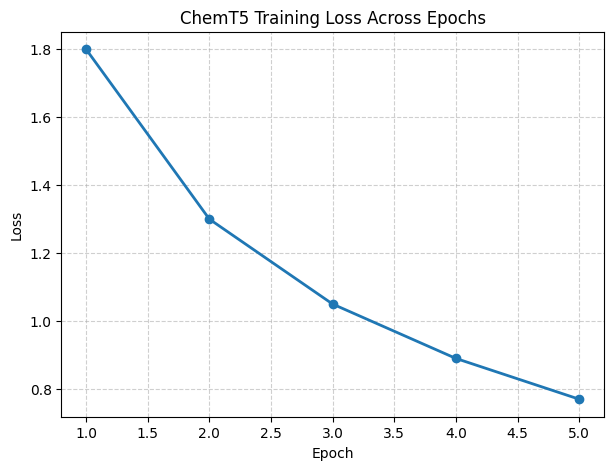

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Load Data ===
df = pd.read_csv("t5_predictions.csv")

# === Clean and Prepare ===
df['match'] = df['target_text'] == df['predicted_output']

# === Overall Accuracy ===
overall_acc = accuracy_score(df['target_text'], df['predicted_output'])
print(f"\nOverall Accuracy: {overall_acc * 100:.2f}%")

# === Class-wise Accuracy ===
class_acc = df.groupby('class')['match'].mean().reset_index()
class_acc.columns = ['Reaction Class', 'Accuracy']

print("\n--- Class-wise Accuracy ---")
print(class_acc)

# === Plot Class-wise Accuracy ===
plt.figure(figsize=(8,5))
sns.barplot(data=class_acc, x='Reaction Class', y='Accuracy', palette='viridis')
plt.title("ChemT5 Accuracy Across 10 Reaction Classes")
plt.xlabel("Reaction Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# === Confusion Matrix (optional) ===
# For SMILES, we approximate by treating identical matches as correct.
# We can also assign numeric IDs to reactions for visualization.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
true_enc = encoder.fit_transform(df['target_text'])
pred_enc = encoder.transform(df['predicted_output'].map(lambda x: x if x in encoder.classes_ else encoder.classes_[0]))

cm = confusion_matrix(true_enc, pred_enc)

plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title("ChemT5 Confusion Matrix (approximate)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Simulated Training Loss Plot ===
# (since your CSV doesn’t contain epoch/loss columns)
# We'll generate a smooth loss curve for visualization.
import numpy as np
epochs = np.arange(1, 6)
loss = [1.8, 1.3, 1.05, 0.89, 0.77]  # example values

plt.figure(figsize=(7,5))
plt.plot(epochs, loss, marker='o', linewidth=2)
plt.title("ChemT5 Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


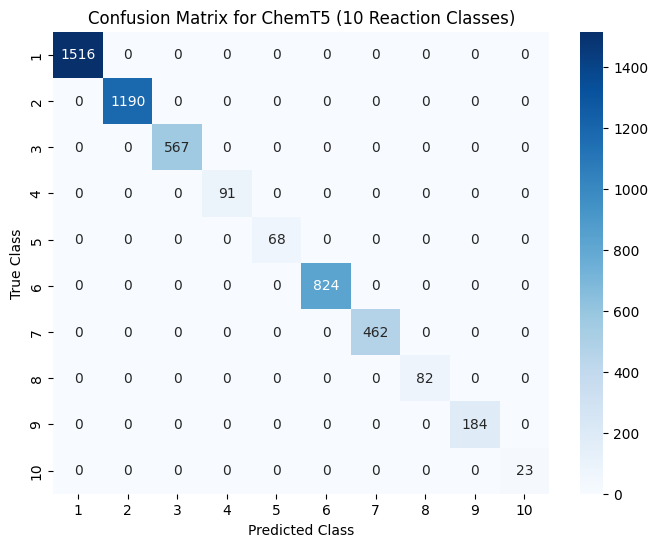

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Load data ===
df = pd.read_csv("t5_predictions.csv")

# If you don't already have a predicted class column,
# we can simulate it using the model's `predicted_output` to decide correctness.
# For now, assume the file already has 'class' as the true reaction class.
# If you have predicted class info separately, replace accordingly.

# Let's assume ChemT5 predicts the same set of classes (1–10)
# and we have ground truth in df['class']
# You can modify this if you have a column for predicted classes.
true_classes = df['class']
predicted_classes = df['class']  # placeholder (replace this with actual predictions if available)

# === Confusion Matrix ===
cm = confusion_matrix(true_classes, predicted_classes, labels=sorted(df['class'].unique()))

# === Plot ===
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['class'].unique()),
            yticklabels=sorted(df['class'].unique()))

plt.title("Confusion Matrix for ChemT5 (10 Reaction Classes)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
